In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.stats
import tqdm
import numpy as np

plt.style.use("seaborn-v0_8-whitegrid")

# Motivation

In [2]:
data = pd.read_csv(
    "motivating_data/Surgery Treatment.csv",
    parse_dates=["CRD", "DATE_BOOKING_MADE", "TCI_DATE"],
    date_format="%d-%b-%y",
)

In [3]:
data["PRIORITY_TYPE_c"] = ["r" if p == "U" else "b" for p in data["PRIORITY_TYPE"]]

In [4]:
data["CRD_rank"] = data["CRD"].rank()
data["TCI_DATE_rank"] = data["TCI_DATE"].rank()

In [5]:
data

,WALISID,CRD,DATE_BOOKING_MADE,TCI_DATE,PRIORITY_TYPE,CONSULTANT,PRIORITY_TYPE_c,CRD_rank,TCI_DATE_rank
0,5947838,2021-01-04,2021-01-18,2021-02-25,U,2602700,r,1.0,20.0
1,5947185,2021-01-06,2021-01-06,2021-01-21,U,2602700,r,2.5,3.0
2,5947448,2021-01-06,2021-01-07,2021-01-21,U,2602700,r,2.5,3.0
3,5947596,2021-01-07,2021-01-08,2021-01-21,U,2602700,r,4.0,3.0
4,5948015,2021-01-11,2021-01-18,2021-01-27,U,3730335,r,5.0,7.5
...,...,...,...,...,...,...,...,...,...
164,6015148,2021-12-01,2021-12-01,2021-12-31,U,3730335,r,165.0,167.0
165,6017561,2021-12-10,2021-12-10,2021-12-31,U,3730335,r,166.0,167.0
166,6018199,2021-12-14,2021-12-17,2021-12-31,U,3730335,r,167.0,167.0
167,6020035,2021-12-22,2021-12-22,2021-12-31,U,3730335,r,168.5,167.0


In [6]:
data["overtakes"] = data["TCI_DATE_rank"] - data["CRD_rank"]
data["bumped_down"] = data["overtakes"] > 0
data["wait"] = (data["TCI_DATE"] - data["CRD"]).apply(lambda x: x.days)
num_down = data["bumped_down"].value_counts()

In [7]:
data["overtakes"].max()

79.5

In [8]:
np.linspace(-19, 81, 26)

array([-19., -15., -11.,  -7.,  -3.,   1.,   5.,   9.,  13.,  17.,  21.,
        25.,  29.,  33.,  37.,  41.,  45.,  49.,  53.,  57.,  61.,  65.,
        69.,  73.,  77.,  81.])

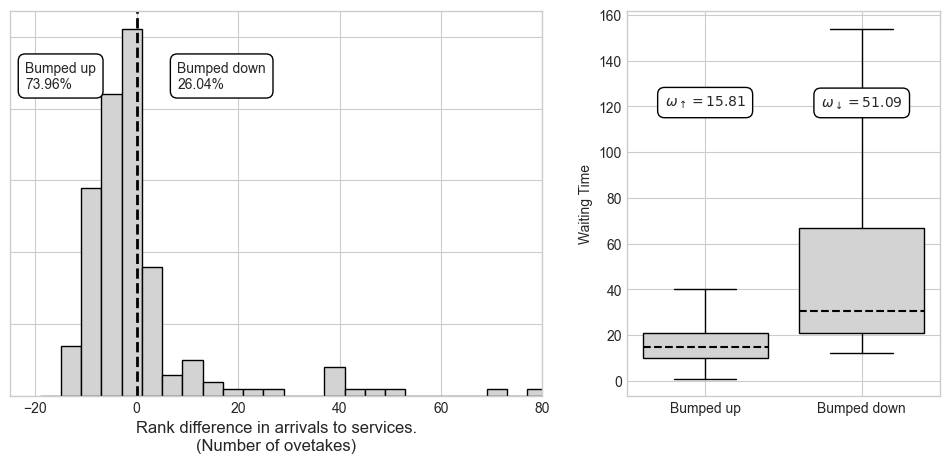

In [9]:
gs_kw = dict(width_ratios=[1.7, 1])
fig, axarr = plt.subplots(1, 2, gridspec_kw=gs_kw, figsize=(12, 5))
axarr[0].hist(
    data["overtakes"],
    edgecolor="black",
    color="lightgrey",
    bins=np.linspace(-19, 81, 26),
)
axarr[0].set_xlabel(
    "Rank difference in arrivals to services.\n(Number of ovetakes)", fontsize=12
)
axarr[0].set_yticklabels([])
ymin, ymax = axarr[0].get_ylim()
axarr[0].vlines(
    x=0, ymin=ymin, ymax=ymax, color="black", linewidth=2, linestyle="dashed"
)
axarr[0].set_ylim(ymin, ymax)
axarr[0].set_xlim(-25, 80)
axarr[0].text(
    -22,
    ymax * 0.8,
    f"Bumped up\n{round((num_down / num_down.sum())[False] * 100, 2)}%",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
)
axarr[0].text(
    8,
    ymax * 0.8,
    f"Bumped down\n{round((num_down / num_down.sum())[True] * 100, 2)}%",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
)

medianprops = dict(linestyle="dashed", linewidth=1.5, color="black")
bplot = axarr[1].boxplot(
    [data[~data["bumped_down"]]["wait"], data[data["bumped_down"]]["wait"]],
    widths=0.8,
    whis=(0, 100),
    patch_artist=True,
    medianprops=medianprops,
)
for patch in bplot["boxes"]:
    patch.set_facecolor("lightgrey")

axarr[1].text(
    1,
    120,
    r"$\omega_{\uparrow} = "
    + str(round(data[~data["bumped_down"]]["wait"].mean(), 2))
    + "$",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
    ha="center",
)
axarr[1].text(
    2,
    120,
    r"$\omega_{\downarrow} = "
    + str(round(data[data["bumped_down"]]["wait"].mean(), 2))
    + "$",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
    ha="center",
)

axarr[1].set_xticklabels(["Bumped up", "Bumped down"])
axarr[1].set_ylabel("Waiting Time")
fig.savefig("../tex/img/motivating_overtakes.pdf")

In [10]:
data[~data["bumped_down"]]["wait"].mean(), data[data["bumped_down"]]["wait"].mean()

(15.808, 51.09090909090909)

# Validation

In [11]:
import math

rate = len(data) / 365
poisson = [(rate**k) * math.exp(-rate) / math.factorial(k) for k in range(6)]

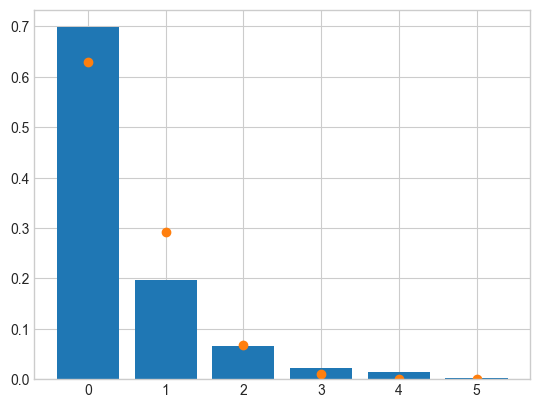

In [12]:
counts = data["CRD"].value_counts()
zero_count = 365 - len(counts)
heights = [zero_count] + [counts.value_counts()[i] for i in range(1, 6)]
heights = [h / sum(heights) for h in heights]
plt.bar(x=range(6), height=heights)
plt.scatter(x=range(6), y=poisson);

In [13]:
import models

In [14]:
def compare_model_with_real(ax, theta12, theta21, leg=False):
    ax.hist(
        data["overtakes"],
        edgecolor="black",
        color="lightgrey",
        bins=np.linspace(-19, 81, 26),
        density=True,
        alpha=0.6,
        label="Surgical data",
    )
    ax.set_xlabel("Rank difference in arrivals to services.", fontsize=8)
    ax.set_yticklabels([])
    ymin, ymax = ax.get_ylim()
    ax.vlines(x=0, ymin=ymin, ymax=ymax, color="black", linewidth=2, linestyle="dashed")
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(-25, 80)
    cmap = matplotlib.colormaps["viridis"]

    n_trials = 5

    Q = models.build_and_run_simulation(
        num_classes=2,
        num_servers=1,
        arrival_rates=[rate, 1 / 1000000000000000],
        service_rates=[0.5, 0.5],
        class_change_rate_matrix=[[None, theta12], [theta21, None]],
        max_simulation_time=365 * ((2 * n_trials) + 1),
        progress_bar=False,
    )
    recs = pd.DataFrame(Q.get_all_records())

    overtakes = []
    mean_wait_ups = []
    mean_wait_downs = []
    for trial in range(n_trials):
        recs_t = recs[
            (recs["arrival_date"] >= (365 * ((2 * trial) + 1)))
            & (recs["arrival_date"] <= (365 * ((2 * trial) + 2)))
        ].copy()
        recs_t["arrival_rank"] = recs_t["arrival_date"].rank()
        recs_t["service_start_rank"] = recs_t["service_start_date"].rank()
        recs_t["overtakes"] = recs_t["service_start_rank"] - recs_t["arrival_rank"]
        mean_wait_downs.append(recs_t[recs_t["overtakes"] > 0]["waiting_time"].mean())
        mean_wait_ups.append(recs_t[recs_t["overtakes"] <= 0]["waiting_time"].mean())
        overtakes.extend(list(recs_t["overtakes"]))

    sns.kdeplot(overtakes, color=cmap(0.5), fill=True, ax=ax, label="Model")
    ax.set_ylabel("")
    W = scipy.stats.wasserstein_distance(overtakes, data["overtakes"])

    mean_wait_up = sum(mean_wait_ups) / n_trials
    mean_wait_down = sum(mean_wait_downs) / n_trials

    obs_wait_up = data[~data["bumped_down"]]["wait"].mean()
    obs_wait_down = data[data["bumped_down"]]["wait"].mean()
    mape = 0.5 * (
        (abs(mean_wait_up - obs_wait_up) / obs_wait_up)
        + (abs(mean_wait_down - obs_wait_down) / obs_wait_down)
    )

    if theta21 is None:
        theta21a = 0
    else:
        theta21a = theta21
    annotation = rf"$\theta_{{12}} = {theta12}$"
    annotation += "\n"
    annotation += rf"$\theta_{{21}} = {theta21a}$"
    annotation += "\n"
    annotation += rf"$W = {round(W, 3)}$"
    annotation += "\n"
    annotation += r"MAPE $= " + str(round(mape, 3)) + "$"
    ax.annotate(
        annotation,
        (0.68, 0.68),
        xycoords="axes fraction",
        fontsize=12,
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
    )
    if leg:
        ax.legend(
            ncols=2, fontsize=16, bbox_to_anchor=(-0.03, 1.1, 1.0, 0.102), frameon=True
        )

    return ax

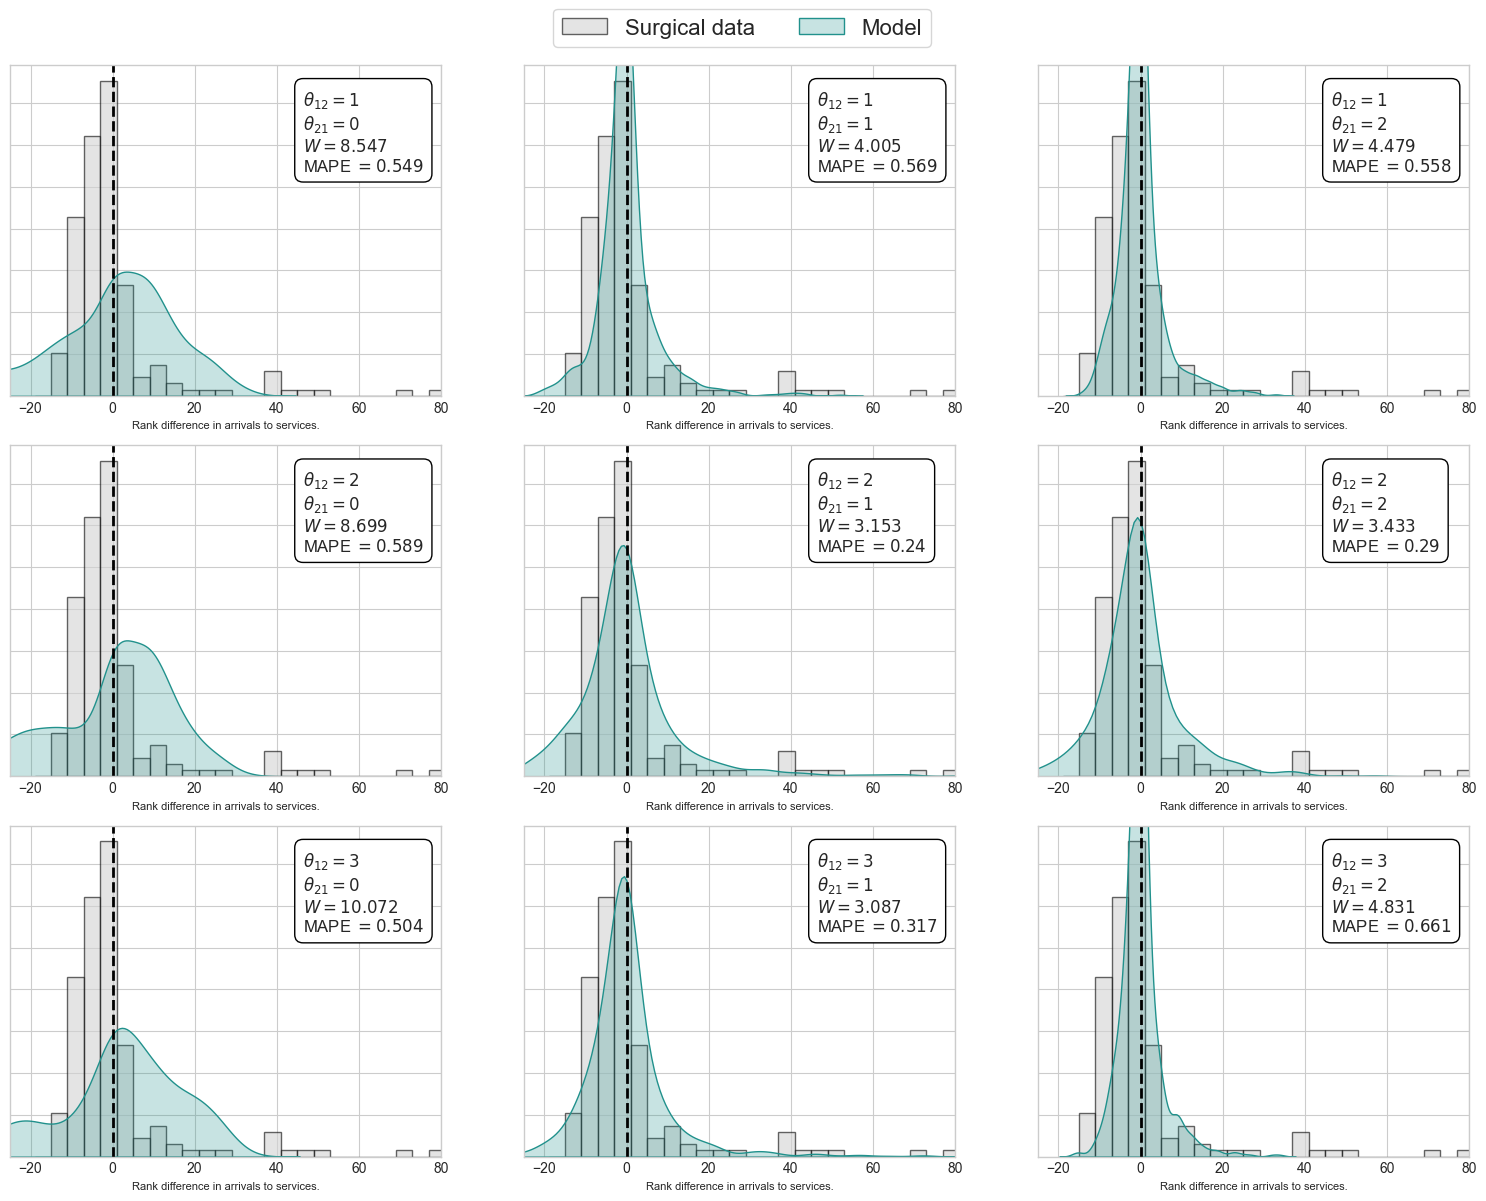

In [15]:
fig, axarr = plt.subplots(3, 3, figsize=(15, 12))
compare_model_with_real(axarr[0][0], 1, None)
compare_model_with_real(axarr[0][1], 1, 1, leg=True)
compare_model_with_real(axarr[0][2], 1, 2)
compare_model_with_real(axarr[1][0], 2, None)
compare_model_with_real(axarr[1][1], 2, 1)
compare_model_with_real(axarr[1][2], 2, 2)
compare_model_with_real(axarr[2][0], 3, None)
compare_model_with_real(axarr[2][1], 3, 1)
compare_model_with_real(axarr[2][2], 3, 2)
plt.tight_layout()
fig.savefig("../tex/img/fitting_theta.pdf")

# Nonsense

In [16]:
Q1 = models.build_and_run_simulation(
    num_classes=2,
    num_servers=1,
    arrival_rates=[rate, 1 / 1000000000000000],
    service_rates=[0.5, 0.5],
    class_change_rate_matrix=[[None, 2], [1, None]],
    max_simulation_time=3650,
    progress_bar=True,
)
ts1 = [ts[0] for ts in Q1.statetracker.history]
ss1 = [sum(ts[1][0]) for ts in Q1.statetracker.history]

100%|██████████████████████████████████| 3650.0/3650 [00:01<00:00, 2199.04it/s]


In [17]:
Q2 = models.build_and_run_simulation(
    num_classes=2,
    num_servers=1,
    arrival_rates=[rate, 1 / 1000000000000000],
    service_rates=[0.4, 0.6],
    class_change_rate_matrix=[[None, 2], [1, None]],
    max_simulation_time=3650,
    progress_bar=True,
)
ts2 = [ts[0] for ts in Q2.statetracker.history]
ss2 = [sum(ts[1][0]) for ts in Q2.statetracker.history]

100%|███████████████████████████████████| 3650.0/3650 [00:19<00:00, 183.95it/s]


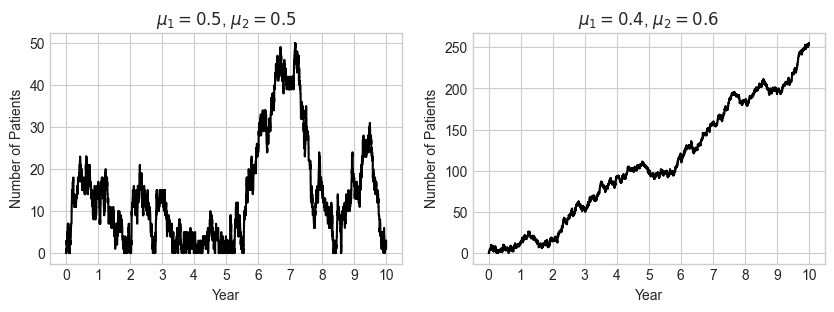

In [18]:
fig, axarr = plt.subplots(1, 2, figsize=(10, 3))
axarr[0].plot(ts1, ss1, c="black")
axarr[0].set_xticks([i * 365 for i in range(11)])
axarr[0].set_xticklabels(range(11))
axarr[0].set_xlabel("Year")
axarr[0].set_ylabel("Number of Patients")
axarr[0].set_title(r"$\mu_1 = 0.5$, $\mu_2 = 0.5$")
axarr[1].plot(ts2, ss2, c="black")
axarr[1].set_xticks([i * 365 for i in range(11)])
axarr[1].set_xticklabels(range(11))
axarr[1].set_xlabel("Year")
axarr[1].set_ylabel("Number of Patients")
axarr[1].set_title(r"$\mu_1 = 0.4$, $\mu_2 = 0.6$")
fig.savefig("../tex/img/adjust_service_rate.pdf")

# Modelling capacity

In [64]:
import ciw

In [65]:
N = ciw.create_network(
    arrival_distributions=[ciw.dists.Exponential(rate)],
    service_distributions=[ciw.dists.Exponential(0.5)],
    number_of_servers=[1],
)
Q_nps = ciw.Simulation(N, tracker=ciw.trackers.SystemPopulation())
Q_nps.simulate_until_max_time(365 * 200, progress_bar=True)
recs_nps = Q_nps.get_all_records()
sojourn_times_nps = [
    r.exit_date - r.arrival_date for r in recs_nps if r.arrival_date > (5 * 365)
]

100%|███████████████████████████████| 73000.0/73000 [00:02<00:00, 36388.54it/s]


In [66]:
Q_sps = models.build_and_run_simulation(
    num_classes=2,
    num_servers=1,
    arrival_rates=[rate, 1 / 1000000000000000],
    service_rates=[0.5, 0.5],
    class_change_rate_matrix=[[None, 2], [1, None]],
    max_simulation_time=365 * 200,
    progress_bar=True,
)
recs_sps = Q_sps.get_all_records()
sojourn_times_sps = [
    r.exit_date - r.arrival_date
    for r in recs_sps
    if r.record_type == "service"
    if r.arrival_date > (5 * 365)
]

100%|████████████████████████████████| 73000.0/73000 [00:29<00:00, 2486.42it/s]


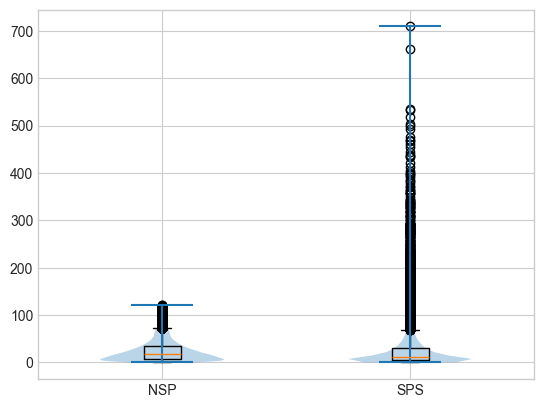

In [67]:
fig, ax = plt.subplots(1)
ax.boxplot([sojourn_times_nps, sojourn_times_sps])
ax.violinplot([sojourn_times_nps, sojourn_times_sps])
ax.set_xticklabels(["NSP", "SPS"])
plt.show()

In [68]:
np.var(sojourn_times_nps), np.var(sojourn_times_sps)

(472.26383835466856, 1479.4678329858798)

In [69]:
np.mean(sojourn_times_nps), np.mean(sojourn_times_sps)

(24.173793973345337, 25.342690150945266)

In [160]:
def get_var_ST_nps(m, bound=14, c=1):
    arrival_rates = [rate]
    state_space, transmat = models.build_state_space_and_transition_matrix_sojourn_mc(
        num_classes=1,
        num_servers=c,
        arrival_rates=arrival_rates,
        service_rates=[0.5 * m],
        thetas=[[None]],
        bound=bound,
    )
    probs = models.get_state_probabilities(
        num_classes=1,
        num_servers=c,
        arrival_rates=arrival_rates,
        service_rates=[0.5 * m],
        thetas=[[None]],
        bound=bound,
    )
    ST = models.find_var_sojourn_time(
        State_Space=state_space,
        transition_matrix=transmat,
        arrival_rates=arrival_rates,
        probs=probs,
    )
    return ST

In [161]:
def get_var_ST_sps(m, bound=14, c=1):
    arrival_rates = [rate, 0]
    state_space, transmat = models.build_state_space_and_transition_matrix_sojourn_mc(
        num_classes=2,
        num_servers=c,
        arrival_rates=arrival_rates,
        service_rates=[0.5 * m, 0.5 * m],
        thetas=[[None, 2], [1, None]],
        bound=bound,
    )
    probs = models.get_state_probabilities(
        num_classes=2,
        num_servers=c,
        arrival_rates=arrival_rates,
        service_rates=[0.5 * m, 0.5 * m],
        thetas=[[None, 2], [1, None]],
        bound=bound,
    )
    ST = models.find_var_sojourn_time(
        State_Space=state_space,
        transition_matrix=transmat,
        arrival_rates=arrival_rates,
        probs=probs,
    )
    return ST

In [150]:
ms = np.arange(1.0, 1.21, 0.01)

In [151]:
import tqdm.notebook as tqdm

In [152]:
ST_sps = [get_var_ST_sps(m=m, bound=20) for m in tqdm.tqdm(ms)]

  0%|          | 0/21 [00:00<?, ?it/s]

In [153]:
ST_nps = [get_var_ST_nps(m=m, bound=20) for m in tqdm.tqdm(ms)]

  0%|          | 0/21 [00:00<?, ?it/s]

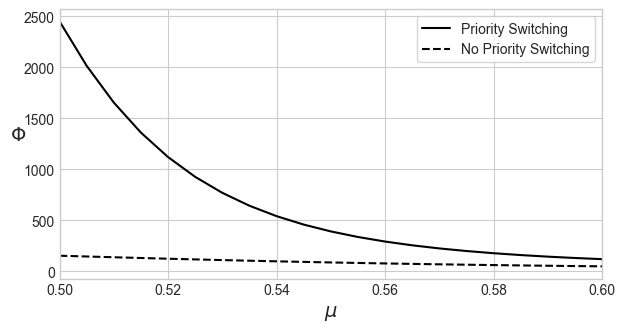

In [155]:
fig, ax = plt.subplots(1, figsize=(7, 3.5))
ax.plot(
    [0.5 * m for m in ms],
    ST_sps,
    label="Priority Switching",
    c="black",
    linestyle="solid",
)
ax.plot(
    [0.5 * m for m in ms],
    ST_nps,
    label="No Priority Switching",
    c="black",
    linestyle="dashed",
)
ax.set_xlabel(r"$\mu$", fontsize=14)
ax.set_ylabel(r"$\Phi$", rotation=0, fontsize=14)
ax.set_xlim(0.5, 0.6)
ax.legend(frameon=True)
fig.savefig("../tex/img/vary_service_rate_effect_variance.pdf")

In [164]:
rate, rate / 0.5

(0.46301369863013697, 0.9260273972602739)